In [1]:
%matplotlib inline
from linearSolveFTS import linearSolve_direct as linearSolve_FTS
from linearSolve import linearSolve_direct  ## now not using matelms, but sympy code as well
from linearSolveKrylovOld import linearSolve_krylov
import numpy as np, matplotlib.pyplot as plt
import pystokes
import matelms as me

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = 3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    #S[i + 5*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)  #-(S[i] + S[i + 3*Np])  ##use tracelessness 
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [5]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    norm_p1 = np.dot(p[::Np],p[::Np])
    norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    p[::Np] = p[::Np]/np.sqrt(norm_p1)
    p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 ##gravity in negative z-direction
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] - 1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np] - 1.)
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
        #S[i + 5*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)  #-(S[i] + S[i + 3*Np])  ##use tracelessness 
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    #ds.directSolve_new(v, o, r, F, T, S, D, rcond=1e-2)
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [6]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [19]:
r

array([-1.5,  1.5,  0. ,  0. ,  0. ,  0. ])

In [7]:
%%time
#initiallize system and forces
ls = linearSolve_direct(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 500.
Npts = 100

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1,
             method='RK45')
X.message

CPU times: user 3min 33s, sys: 1min 12s, total: 4min 46s
Wall time: 36.8 s


'The solver successfully reached the end of the integration interval.'

In [8]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [9]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

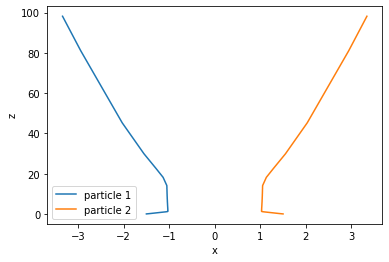

In [10]:
##x-y plot like in Ishikawa
plt.plot(pos1[:,0], pos1[:,2], label='particle 1')
plt.plot(pos2[:,0], pos2[:,2], label='particle 2')
plt.xlabel('x')
plt.ylabel('z')
#plt.xlim(-10,10)
plt.legend()
plt.show()

In [11]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0543503295321592, 6.681265727185298)

In [12]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmax)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([64]),)

In [13]:
xik,yik,zik ##they go out of plane? not anymore! 

(-6.681265727185298, 0.0, 0.0)

In [14]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [15]:
print(pos1[:,0] + pos2[:,0]) ##should be zero due to symmetry

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16 -4.44089210e-16 -4.44089210e-16
 -6.66133815e-16 -1.11022

In [16]:
orientations = X.y.T[:,3*Np:6*Np]
or1 = orientations[:,::Np]
or2 = orientations[:,1::Np]

In [17]:
or1[:,0] + or2[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -2.08166817e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17,
       -1.21430643e-17, -1.30104261e-17, -1.30104261e-17, -1.56125113e-17,
       -1.56125113e-17, -

In [18]:
or1[:,2] - or2[:,2]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.11022302e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [51]:
or1[:,0]

array([ 0.42261826,  0.42258778,  0.42228016,  0.41889734,  0.38937474,
        0.38249567,  0.37500209,  0.36650156,  0.35452659,  0.33858661,
        0.33281298,  0.32706319,  0.31118514,  0.30349848,  0.2959062 ,
        0.27671506,  0.27022443,  0.26381227,  0.24444762,  0.23707101,
        0.22981347,  0.21252903,  0.20589957,  0.19938098,  0.18207737,
        0.17545168,  0.16895287,  0.15329147,  0.14807415,  0.14294387,
        0.12774317,  0.12204425,  0.11646383,  0.10308133,  0.09847768,
        0.09396035,  0.08082567,  0.07582025,  0.07093106,  0.0596648 ,
        0.05584195,  0.05209387,  0.04106323,  0.03693056,  0.03289714,
        0.02349032,  0.02018262,  0.01694582,  0.00792302,  0.00483998,
        0.00182598, -0.00534304, -0.00925077, -0.01302544, -0.01977042,
       -0.02216564, -0.02451247, -0.03079788, -0.03780586, -0.06561096,
       -0.06602286, -0.0556068 , -0.04155546, -0.03040716, -0.02820301])

In [52]:
or1[:,2]

array([0.90630779, 0.906322  , 0.90646537, 0.9080336 , 0.92107943,
       0.92395728, 0.92702397, 0.93041744, 0.93504593, 0.94093523,
       0.94299285, 0.94500247, 0.95034931, 0.95283192, 0.955217  ,
       0.96095202, 0.96279736, 0.96457405, 0.9696625 , 0.97149233,
       0.97323469, 0.97715475, 0.97857313, 0.97992205, 0.98328421,
       0.98448804, 0.98562413, 0.98818102, 0.98897626, 0.9897308 ,
       0.99180728, 0.99252466, 0.99319493, 0.99467293, 0.99513926,
       0.99557594, 0.99672825, 0.9971215 , 0.99748122, 0.99821847,
       0.99843962, 0.99864219, 0.99915655, 0.99931783, 0.99945874,
       0.99972406, 0.99979631, 0.99985641, 0.99996861, 0.99998829,
       0.99999833, 0.99998573, 0.99995721, 0.99991517, 0.99980455,
       0.99975431, 0.99969952, 0.99952563, 0.9992851 , 0.99784528,
       0.99781811, 0.99845274, 0.9991362 , 0.9995376 , 0.99960222])